# Risk Sentiment - Equities

## Imports

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import pmp_functions_v5 as pmp
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

path = "../../Data_Ryan"

## Global Variables

In [2]:
frequency = 1
t_cost = 0
target_vol = 0.1
min_regions = 4
lag = 1

## Data

### Riskfree Data

In [3]:
# --- Load Riskfree Rate ---
factors_data = pd.read_excel(
    f"{path}/Factors.xlsx",
    index_col = 0,
    parse_dates = True
)

factors_data.index = pd.to_datetime(factors_data.index, format='%Y%m')
factors_data.index = factors_data.index + pd.offsets.MonthEnd(0)
factors_data /= 100

riskfree = factors_data["RF"].resample('ME').last()
riskfree

/var/folders/bl/ywj9s7j57_qf7pwls_sv_w9r0000gn/T/ipykernel_33588/2677495952.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  factors_data = pd.read_excel(


1926-07-31    0.0022
1926-08-31    0.0025
1926-09-30    0.0023
1926-10-31    0.0032
1926-11-30    0.0031
               ...  
2025-06-30    0.0034
2025-07-31    0.0034
2025-08-31    0.0038
2025-09-30    0.0033
2025-10-31    0.0037
Freq: ME, Name: RF, Length: 1192, dtype: float64

### Factor Data

In [4]:
# --- Load Factors Data ---
famafrench_data = pd.read_csv(
    f"{path}/famafrench_factors.csv",
    index_col = 0,
    parse_dates = True
)

famafrench_data.index = pd.to_datetime(famafrench_data.index, format='%Y%m')
famafrench_data.index = famafrench_data.index + pd.offsets.MonthEnd(0)
famafrench_data.dropna(inplace=True)
famafrench_data

/var/folders/bl/ywj9s7j57_qf7pwls_sv_w9r0000gn/T/ipykernel_33588/297690613.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  famafrench_data = pd.read_csv(


,MKT-RF,SMB,HML,RMW,CMA,UMD,BAB
DATE,,,,,,,
1980-01-31,0.0550,0.0188,0.0185,-0.0184,0.0189,0.0745,0.0695
1980-02-29,-0.0123,-0.0162,0.0059,-0.0095,0.0292,0.0789,-0.0132
1980-03-31,-0.1289,-0.0697,-0.0096,0.0182,-0.0105,-0.0958,-0.1181
1980-04-30,0.0396,0.0105,0.0103,-0.0218,0.0034,-0.0048,0.0574
1980-05-31,0.0526,0.0200,0.0038,0.0043,-0.0063,-0.0118,0.0618
...,...,...,...,...,...,...,...
2025-05-31,0.0606,-0.0072,-0.0288,0.0129,0.0251,0.0221,0.0256
2025-06-30,0.0486,-0.0002,-0.0160,-0.0320,0.0145,-0.0264,0.0527
2025-07-31,0.0198,-0.0015,-0.0127,-0.0029,-0.0208,-0.0096,0.0184


### Benchmark Data

In [5]:
# --- Benchmark Data ---
benchmark_data = pd.read_excel(
    f"{path}/Benchmarks.xlsx",
    index_col = 0,
    parse_dates = True
)

benchmark_data.index = pd.to_datetime(benchmark_data.index)
benchmark_data = benchmark_data.resample('ME').last()
display(benchmark_data)

benchmark_TR = benchmark_data[['60/40']].pct_change()
benchmark_XR = benchmark_TR.sub(riskfree, axis = 0)

benchmark_TR.columns = ['Benchmark Total Return']
benchmark_XR.columns = ['Benchmark Excess Return']
benchmark_returns = pd.concat([benchmark_TR, benchmark_XR], axis = 1).dropna()

display(benchmark_returns)

benchmark_TR = benchmark_TR.squeeze()

,S&P 500,MSCI World,FTSE WGBI,60/40
Date,,,,
1986-12-31,242.1700,NaN,156.5737,14.640989
1987-01-31,274.7800,NaN,161.2733,15.080442
1987-02-28,285.6377,NaN,163.7959,15.316327
1987-03-31,293.8792,NaN,167.5858,15.670715
1987-04-30,291.2698,NaN,169.5120,15.850831
...,...,...,...,...
2025-07-31,14412.5527,8214.1572,899.0753,418.585408
2025-08-31,14704.7217,8431.0801,911.3233,428.564691
2025-09-30,15240.0381,8705.7139,916.8774,440.268260


,Benchmark Total Return,Benchmark Excess Return
1987-01-31,0.030015,0.025815
1987-02-28,0.015642,0.011342
1987-03-31,0.023138,0.018438
1987-04-30,0.011494,0.007094
1987-05-31,-0.009907,-0.013707
...,...,...
2025-06-30,0.038273,0.034873
2025-07-31,0.006737,0.003337
2025-08-31,0.023840,0.020040
2025-09-30,0.027309,0.024009


### Equity Data

In [6]:
# --- Load Equity Price Data ---
equity_prices = pd.read_excel(
    f"{path}/Equity Data.xlsx",
    index_col = 0,
    parse_dates = True
)
equity_prices.index = pd.to_datetime(equity_prices.index)
equity_prices.index = equity_prices.index + pd.offsets.MonthEnd(0)

equity_prices

,US,AU,CH,JP,UK,EM,EU
Date,,,,,,,
1997-09-30,1206.821289,NaN,NaN,7.33429,7487.55371,NaN,NaN
1997-10-31,1168.258667,NaN,NaN,6.82642,7084.46436,NaN,NaN
1997-11-30,1207.453491,NaN,NaN,6.34016,7152.55615,NaN,NaN
1997-12-31,1223.840210,NaN,NaN,5.86087,7365.37451,NaN,NaN
1998-01-31,1234.778442,NaN,NaN,6.36481,7690.75049,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,6308.888672,5641.31592,14994.83984,19.64406,12121.12598,14955.800000,6276.48438
2025-07-31,6430.451172,5627.64307,14552.98438,19.41757,12131.93066,15094.600000,6109.94238
2025-08-31,6529.819336,5881.38037,15274.74121,20.75129,12521.77637,15223.700000,6284.96094


In [7]:
returns = equity_prices.pct_change()
returns

,US,AU,CH,JP,UK,EM,EU
Date,,,,,,,
1997-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-10-31,-0.031954,NaN,NaN,-0.069246,-0.053835,NaN,NaN
1997-11-30,0.033550,NaN,NaN,-0.071232,0.009611,NaN,NaN
1997-12-31,0.013571,NaN,NaN,-0.075596,0.029754,NaN,NaN
1998-01-31,0.008938,NaN,NaN,0.085984,0.044176,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,0.047850,0.034649,0.008742,0.018397,0.017408,0.087457,0.024923
2025-07-31,0.019268,-0.002424,-0.029467,-0.011530,0.000891,0.009281,-0.026534
2025-08-31,0.015453,0.045088,0.049595,0.068686,0.032134,0.008553,0.028645


## Signal Generation

In [8]:
# --- Compute Risk Sentiment Signal ---
risk_sentiment_signal = equity_prices.pct_change(12).resample('ME').last()
risk_sentiment_signal

,US,AU,CH,JP,UK,EM,EU
Date,,,,,,,
1997-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,0.089128,0.068200,0.135337,0.154598,0.144851,0.289415,0.182202
2025-07-31,0.102824,0.049903,0.052154,0.073431,0.108819,0.101297,0.147454
2025-08-31,0.099490,0.061966,0.057742,0.147609,0.115843,0.169668,0.137625


In [ ]:
# --- Composite Signal Construction ---
# Logic: For Equities, we want increasing Risk Sentiment (+)
risk_sentiment_signal = risk_sentiment_signal

display("Risk Sentiment Signal:")
display(risk_sentiment_signal)

'Risk Sentiment Signal:'

,US,AU,CH,JP,UK,EM,EU
Date,,,,,,,
1997-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,0.089128,0.068200,0.135337,0.154598,0.144851,0.289415,0.182202
2025-07-31,0.102824,0.049903,0.052154,0.073431,0.108819,0.101297,0.147454
2025-08-31,0.099490,0.061966,0.057742,0.147609,0.115843,0.169668,0.137625


### Portfolio Construction

In [10]:
# --- Compute Weights ---
weights, scaling_factors, weights_raw = pmp.make_country_weights_ls_vol(
    signal=risk_sentiment_signal,
    returns=returns,
    min_regions=min_regions,
    signal_lag= lag,
    vol_target=target_vol,
    vol_lookback=24
)

weights

,US,AU,CH,JP,UK,EM,EU
2001-09-30,-0.301452,0.502420,0.301452,-0.502420,0.100484,NaN,-0.100484
2001-10-31,-0.097841,0.489205,0.293523,-0.489205,0.097841,NaN,-0.293523
2001-11-30,-0.099274,0.496371,0.297823,-0.496371,0.099274,NaN,-0.297823
2001-12-31,0.287890,0.479817,-0.095963,-0.479817,0.095963,NaN,-0.287890
2002-01-31,0.274924,0.458206,-0.091641,-0.458206,0.091641,NaN,-0.274924
...,...,...,...,...,...,...,...
2025-05-31,-0.273682,-0.410522,0.410522,0.000000,-0.136841,0.273682,0.136841
2025-06-30,-0.293638,-0.440458,0.293638,0.146819,-0.146819,0.440458,0.000000
2025-07-31,-0.293452,-0.440178,-0.146726,0.146726,0.000000,0.440178,0.293452
2025-08-31,0.147333,-0.441999,-0.294666,-0.147333,0.294666,0.000000,0.441999


In [11]:
weights = pmp.append_final_zero_row(weights)

## Backtest

In [12]:
results = pmp.run_cc_strategy(
    weights = weights,
    returns = returns,
    rf = riskfree,
    frequency=1,
    t_cost= t_cost,
    benchmark = benchmark_TR
)

results

results.to_csv('macroRS_equity.csv')

## Performance Summary

In [13]:
pmp.run_perf_summary_benchmark_vs_strategy(results, alreadyXs = True)

,Benchmark,Strategy
Arithm Avg Total Return,7.3793,-4.9260
Arithm Avg Xs Return,5.7716,-6.5338
Std Xs Returns,9.6844,13.4348
Sharpe Arithmetic,0.5960,-0.4863
Geom Avg Total Return,7.1311,-5.7815
Geom Avg Xs Return,5.5128,-7.3998
Sharpe Geometric,0.5692,-0.5508
Min Xs Return,-10.2114,-38.7585
Max Xs Return,8.6715,9.9153
Skewness,-0.4922,-3.4203


In [14]:
# calculate yearly vol annualized
tmp = results.copy()
tmp["year"] = tmp.index.year

yearly_std = tmp.groupby("year")["ret_net"].std()
yearly_vol_ann = tmp.groupby("year")["ret_net"].std() * (12 ** 0.5)
yearly_vol_ann


year
2001    0.019888
2002    0.132954
2003    0.078602
2004    0.055364
2005    0.126354
2006    0.066548
2007    0.205109
2008    0.163976
2009    0.085736
2010    0.114077
2011    0.091480
2012    0.098459
2013    0.087806
2014    0.140260
2015    0.086495
2016    0.051824
2017    0.104527
2018    0.137692
2019    0.089710
2020    0.126410
2021    0.073810
2022    0.102285
2023    0.093956
2024    0.103672
2025    0.417047
Name: ret_net, dtype: float64

## Plots

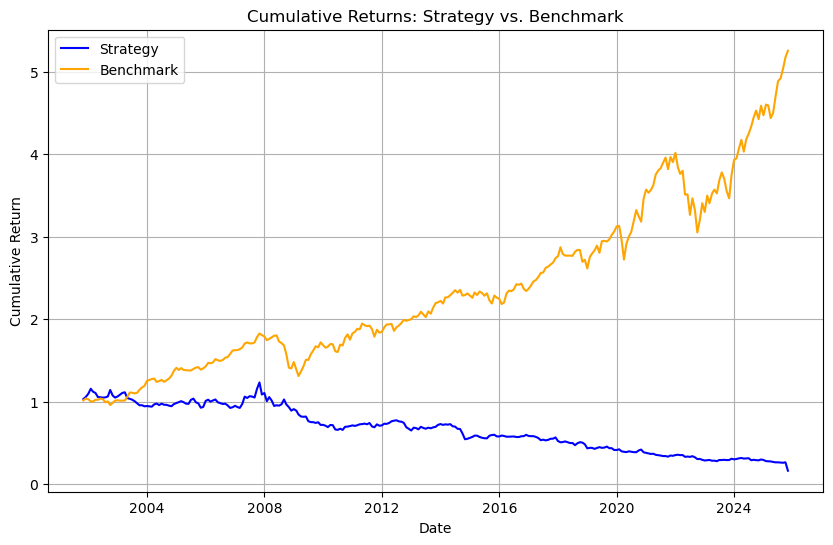

In [15]:
plt.figure(figsize=(10, 6))
plt.plot((1 + results["ret_net"]).cumprod(), label="Strategy", color="blue")
plt.plot((1 + results["ret_bm"]).cumprod(), label="Benchmark", color="orange")
plt.title("Cumulative Returns: Strategy vs. Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
#make the y-axis logarithmic
#plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()